![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

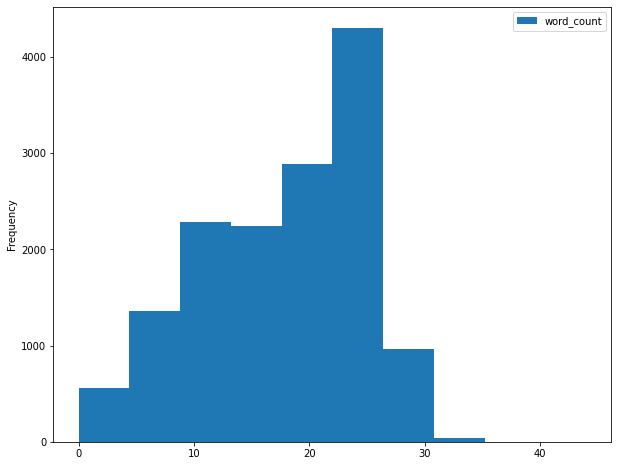

In [5]:
tweets['word_count'] = tweets['text'].apply(lambda x: len(str(x).split()))
ax = tweets.plot.hist(column=["word_count"], figsize=(10, 8))

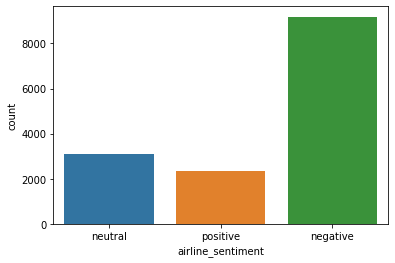

In [6]:
ax = sns.countplot(x="airline_sentiment", data=tweets)

In [7]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

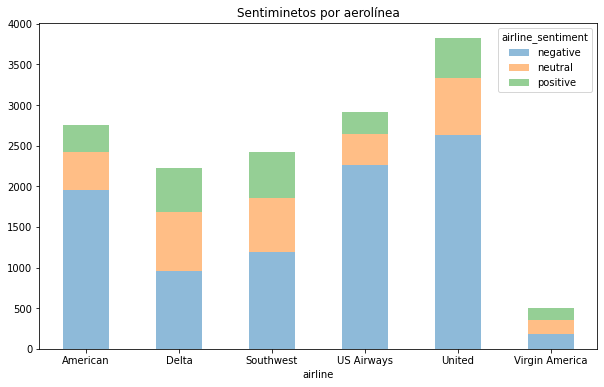

In [9]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [10]:
import re
import string
import spacy
nlp = spacy.load('en_core_web_lg')
from gensim.corpora.textcorpus import strip_multiple_whitespaces
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
#from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score



# For word lemmitization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# for word Stemming
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to /Users/natalia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Tratamiento de datos desbalanceados

In [11]:
from imblearn.under_sampling import RandomUnderSampler
balanced = RandomUnderSampler(random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
def preprocess_tweet_punto1(tweet):
    """
    Function to process the the tweet text and tranform it into format usable by Machine learning models
    """
    # remove line breaks
    tweet = tweet.replace('\n', ' ')
    # to convert all the characters of the tweet into lower case alphabets
    tweet = tweet.lower()
    #remove numbers
    tweet = re.sub(r'[0-9]+', '', tweet) #remove numbers
    # Remove urls from the tweets
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    #remove emails
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    # Remove user related references from the tweets:: '@' and '#' 
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations from the tweets
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    return tweet


In [13]:
# Preprocessing data before feeding it to ML models
processed_punto1 = tweets['text'].apply(preprocess_tweet_punto1)
pd.DataFrame(processed_punto1).head()

,text
tweet_id,
570306133677760513,what said
570301130888122368,plus youve added commercials to the experience...
570301083672813571,i didnt today must mean i need to take another...
570301031407624196,its really aggressive to blast obnoxious enter...
570300817074462722,and its a really big bad thing about it


In [14]:
# Separación de variables predictoras (X) y de variable de interés (y)
X_punto1 = processed_punto1.values
y_punto1 = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1}).values


In [15]:
# RandomUnderSampler is a fast and easy way to balance the data by randomly 
X_punto1= X_punto1.reshape(-1, 1)
y_punto1= y_punto1.reshape(-1, 1)

x1_resampled, y1_resampled = balanced.fit_resample(X_punto1, y_punto1)

In [16]:
# Separación de datos en set de entrenamiento y test
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1_resampled, y1_resampled, test_size=0.2, random_state=42)

In [17]:
#Tokenization 
tokenizer = CountVectorizer()

xtrain1_toke = tokenizer.fit_transform(xtrain1.ravel())
print('Features Train:', xtrain1_toke.shape[0])

xtest1_toke = tokenizer.transform(xtest1.ravel())
print('Features Test: ', xtest1_toke.shape[0])

Features Train: 5671
Features Test:  1418


In [18]:
ModelPunto1 = RandomForestClassifier(n_estimators=100)
ModelPunto1.fit(xtrain1_toke, ytrain1)
print(pd.Series(cross_val_score(ModelPunto1, xtrain1_toke, ytrain1, cv=10)).describe())

count    10.000000
mean      0.720329
std       0.018460
min       0.687831
25%       0.709436
50%       0.721340
75%       0.731922
max       0.753086
dtype: float64


In [19]:
# Predicting the values and the Accuracy Score
predict_model1 = ModelPunto1.predict(xtest1_toke)
print("Accuracy Score for RandomForestClassifier is :: ", accuracy_score(ytest1, predict_model1))

# Classification Report :
target = ['negative','neutral','positive']
print("Classification_Report :: \n\n", classification_report(ytest1, predict_model1, target_names=target))

Accuracy Score for RandomForestClassifier is ::  0.6960507757404796
Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.75      0.72      0.73       487
     neutral       0.61      0.67      0.64       476
    positive       0.74      0.70      0.72       455

    accuracy                           0.70      1418
   macro avg       0.70      0.70      0.70      1418
weighted avg       0.70      0.70      0.70      1418



### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [20]:
def preprocess_tweet_punto2(tweet):
    """
    Function to process the the tweet text and tranform it into format usable by Machine learning models
    """
    # remove line breaks
    tweet = tweet.replace('\n', ' ')
    # to convert all the characters of the tweet into lower case alphabets
    tweet = tweet.lower()
    #remove numbers
    tweet = re.sub(r'[0-9]+', '', tweet) #remove numbers
    # Remove urls from the tweets
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    #remove emails
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    # Remove user related references from the tweets:: '@' and '#' 
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations from the tweets
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords from the tweets and Remove punctuations from the tweets
    filtered_words = [t.orth_ for t in nlp(tweet) if not t.is_punct | t.is_stop]
    joined_text = " ".join(filtered_words)
    return joined_text


In [21]:
# Preprocessing data before feeding it to ML models
processed_punto2 = tweets['text'].apply(preprocess_tweet_punto2)
pd.DataFrame(processed_punto2).head()

,text
tweet_id,
570306133677760513,said
570301130888122368,plus ve added commercials experience tacky
570301083672813571,nt today mean need trip
570301031407624196,aggressive blast obnoxious entertainment guest...
570300817074462722,big bad thing


In [22]:
# Separación de variables predictoras (X) y de variable de interés (y)
X_punto2 = processed_punto2.values
y_punto2 = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1}).values

In [23]:
# RandomUnderSampler is a fast and easy way to balance the data by randomly 
X_punto2= X_punto2.reshape(-1, 1)
y_punto2= y_punto2.reshape(-1, 1)

x2_resampled, y2_resampled = balanced.fit_resample(X_punto2, y_punto2)

In [24]:
# Separación de datos en set de entrenamiento y test
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2_resampled, y2_resampled, test_size=0.2, random_state=42)

In [25]:
#Tokenization 
tokenizer2 = CountVectorizer(
    ngram_range=(1, 1),
    min_df=3, max_df=0.9
)
tokenizer2.stop_words_ = {}


xtrain2_toke = tokenizer2.fit_transform(xtrain2.ravel())
print('Features Train: ', xtrain2_toke.shape[0])

xtest2_toke = tokenizer2.transform(xtest2.ravel())
print('Features Test: ', xtest2_toke.shape[0])

Features Train:  5671
Features Test:  1418


In [26]:
ModelPunto2 = RandomForestClassifier(n_estimators=100)
ModelPunto2.fit(xtrain2_toke, ytrain2)
print(pd.Series(cross_val_score(ModelPunto2, xtrain2_toke, ytrain2, cv=10)).describe())

count    10.000000
mean      0.693356
std       0.020141
min       0.661376
25%       0.687831
50%       0.691358
75%       0.697531
max       0.737213
dtype: float64


In [27]:
# Predicting the values and the Accuracy Score
predict_model2 = ModelPunto2.predict(xtest2_toke)
print("Accuracy Score for RandomForestClassifier is :: ", accuracy_score(ytest2, predict_model2))

# Classification Report :
target = ['negative','neutral','positive']
print("Classification_Report :: \n\n", classification_report(ytest2, predict_model2, target_names=target))

Accuracy Score for RandomForestClassifier is ::  0.6741889985895627
Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.72      0.66      0.69       487
     neutral       0.60      0.63      0.62       476
    positive       0.71      0.74      0.72       455

    accuracy                           0.67      1418
   macro avg       0.68      0.68      0.68      1418
weighted avg       0.68      0.67      0.67      1418



### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [69]:
def preprocess_tweet_punto3(tweet):
    """
    Function to process the the tweet text and tranform it into format usable by Machine learning models
    """
    # remove line breaks
    tweet = tweet.replace('\n', ' ')
    # to convert all the characters of the tweet into lower case alphabets
    tweet = tweet.lower()
    #remove numbers
    tweet = re.sub(r'[0-9]+', '', tweet) #remove numbers
    # Remove urls from the tweets
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    #remove emails
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    # Remove user related references from the tweets:: '@' and '#' 
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations from the tweets
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Lemmatizerr
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='v') for w in tweet.split()]

    joined_text = " ".join(lemma_words)
    return joined_text

    return tweet




In [70]:
# Preprocessing data before feeding it to ML models
processed_punto3 = tweets['text'].apply(preprocess_tweet_punto3)
pd.DataFrame(processed_punto3).head()

,text
tweet_id,
570306133677760513,what say
570301130888122368,plus youve add commercials to the experience t...
570301083672813571,i didnt today must mean i need to take another...
570301031407624196,its really aggressive to blast obnoxious enter...
570300817074462722,and its a really big bad thing about it


In [71]:
# Separación de variables predictoras (X) y de variable de interés (y)
X_punto3 = processed_punto3.values
y_punto3 = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1}).values

In [72]:
# RandomUnderSampler is a fast and easy way to balance the data by randomly 
X_punto3= X_punto3.reshape(-1, 1)
y_punto3= y_punto3.reshape(-1, 1)

x3_resampled, y3_resampled = balanced.fit_resample(X_punto3, y_punto3)

In [73]:
# Separación de datos en set de entrenamiento y test
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x3_resampled, y3_resampled, test_size=0.2, random_state=42)

In [74]:
vect_lemas = CountVectorizer()

xtrain3_toke = vect_lemas.fit_transform(xtrain3.ravel())
print('Features Train: ', xtrain2_toke.shape[0])

xtest3_toke = vect_lemas.transform(xtest3.ravel())
print('Features Test: ', xtest2_toke.shape[0])

Features Train:  5671
Features Test:  1418


In [75]:
ModelPunto3 = RandomForestClassifier(n_estimators=100)
ModelPunto3.fit(xtrain3_toke, ytrain3)
print(pd.Series(cross_val_score(ModelPunto3, xtrain3_toke, ytrain3, cv=10)).describe())

count    10.000000
mean      0.717687
std       0.024338
min       0.687831
25%       0.701058
50%       0.714537
75%       0.729277
max       0.772487
dtype: float64


In [77]:
# Predicting the values and the Accuracy Score
predict_model3 = ModelPunto3.predict(xtest3_toke)
print("Accuracy Score for RandomForestClassifier is :: ", accuracy_score(ytest3, predict_model3))

# Classification Report :
target = ['negative','neutral','positive']
print("Classification_Report : \n\n", classification_report(ytest3, predict_model3, target_names=target))

Accuracy Score for RandomForestClassifier is ::  0.6995768688293371
Classification_Report : 

               precision    recall  f1-score   support

    negative       0.73      0.75      0.74       487
     neutral       0.62      0.64      0.63       476
    positive       0.75      0.71      0.73       455

    accuracy                           0.70      1418
   macro avg       0.70      0.70      0.70      1418
weighted avg       0.70      0.70      0.70      1418



### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [36]:
def preprocess_tweet_punto4(tweet):
    """
    Function to process the the tweet text and tranform it into format usable by Machine learning models
    """
    # remove line breaks
    tweet = tweet.replace('\n', ' ')
    # to convert all the characters of the tweet into lower case alphabets
    tweet = tweet.lower()
    #remove numbers
    tweet = re.sub(r'[0-9]+', '', tweet) #remove numbers
    # Remove urls from the tweets
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    #remove emails
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    # Remove user related references from the tweets:: '@' and '#' 
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations from the tweets
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords from the tweets and Remove punctuations from the tweets
    filtered_words = [t.orth_ for t in nlp(tweet) if not t.is_punct | t.is_stop]

    # Lemmatizerr
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='v') for w in filtered_words]
    joined_text = " ".join(lemma_words)
    return joined_text


In [37]:
# Preprocessing data before feeding it to ML models
processed_punto4 = tweets['text'].apply(preprocess_tweet_punto4)
pd.DataFrame(processed_punto4).head()

,text
tweet_id,
570306133677760513,say
570301130888122368,plus ve add commercials experience tacky
570301083672813571,nt today mean need trip
570301031407624196,aggressive blast obnoxious entertainment guest...
570300817074462722,big bad thing


In [38]:
# Separación de variables predictoras (X) y de variable de interés (y)
X_punto4 = processed_punto4.values
y_punto4 = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1}).values

In [39]:
# RandomUnderSampler is a fast and easy way to balance the data by randomly 
X_punto4= X_punto4.reshape(-1, 1)
y_punto4= y_punto4.reshape(-1, 1)

x4_resampled, y4_resampled = balanced.fit_resample(X_punto4, y_punto4)

In [40]:
# Separación de datos en set de entrenamiento y test
xtrain4, xtest4, ytrain4, ytest4 = train_test_split(x4_resampled, y4_resampled, test_size=0.2, random_state=42)

In [41]:
#Tokenization 
vect_lemas4 = CountVectorizer()
vect_lemas4.stop_words_ = {}


xtrain4_toke = vect_lemas4.fit_transform(xtrain4.ravel())
print('Features Train: ', xtrain4_toke.shape[0])

xtest4_toke = vect_lemas4.transform(xtest4.ravel())
print('Features Test: ', xtest4_toke.shape[0])

Features Train:  5671
Features Test:  1418


In [42]:
# Entrenamiento del modelo
ModelPunto4 = RandomForestClassifier(n_estimators=100)
ModelPunto4.fit(xtrain4_toke, ytrain4)
print(pd.Series(cross_val_score(ModelPunto4, xtrain4_toke, ytrain4, cv=10)).describe())

count    10.000000
mean      0.702170
std       0.019490
min       0.659612
25%       0.695460
50%       0.701058
75%       0.712963
max       0.728395
dtype: float64


In [43]:
 # Predicting the values and the Accuracy Score
predict_model4 = ModelPunto4.predict(xtest4_toke)
print("Accuracy Score for RandomForestClassifier is :: ", accuracy_score(ytest4, predict_model4))

# Classification Report :
target = ['negative','neutral','positive']
print("Classification_Report :: \n\n", classification_report(ytest4, predict_model4, target_names=target))

Accuracy Score for RandomForestClassifier is ::  0.6798307475317349
Classification_Report :: 

               precision    recall  f1-score   support

    negative       0.72      0.68      0.70       487
     neutral       0.59      0.64      0.61       476
    positive       0.74      0.73      0.73       455

    accuracy                           0.68      1418
   macro avg       0.68      0.68      0.68      1418
weighted avg       0.68      0.68      0.68      1418



### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

### Reporte de rendimiento de los modelos

In [44]:
# Classification Report - PUNTO 1:
print("Classification_Report - Punto1: \n\n", classification_report(ytest1, predict_model1, target_names=target))

# Classification Report - PUNTO 2:
print("Classification_Report - Punto2: \n\n", classification_report(ytest2, predict_model2, target_names=target))

# Classification Report - PUNTO 3:
print("Classification_Report - Punto3: \n\n", classification_report(ytest3, predict_model3, target_names=target))

# Classification Report - PUNTO 4:
print("Classification_Report - Punto4: \n\n", classification_report(ytest4, predict_model4, target_names=target))


Classification_Report - Punto1: 

               precision    recall  f1-score   support

    negative       0.75      0.72      0.73       487
     neutral       0.61      0.67      0.64       476
    positive       0.74      0.70      0.72       455

    accuracy                           0.70      1418
   macro avg       0.70      0.70      0.70      1418
weighted avg       0.70      0.70      0.70      1418

Classification_Report - Punto2: 

               precision    recall  f1-score   support

    negative       0.72      0.66      0.69       487
     neutral       0.60      0.63      0.62       476
    positive       0.71      0.74      0.72       455

    accuracy                           0.67      1418
   macro avg       0.68      0.68      0.68      1418
weighted avg       0.68      0.67      0.67      1418

Classification_Report - Punto3: 

               precision    recall  f1-score   support

    negative       0.74      0.70      0.72       487
     neutral       0.62 

A partir de los resultados anteriores se puede determinar los siguientes analisis:

* Para los puntos del 1-4 se dejo un preprocesamiento general en el cual para todos los puntos se realiza una limpieza de "line breaaks", se pasa todo a minuscula, se elimina los números, los urls, los emails, la puntación y caracteres especiales como "#" y "@". Esto con la finalidad de tener un texto con menor sesgo y mas limpio, ya que tener caracteres o números indeceados va generar un mal rendimiento en el modelo, debido a que no realizan un aporte que genere una diferenciación entre los texto, sino que genera un ruido el cual puede confundir al modelo y causar una mala predicción.

* A partir de la grafica de distribución de clases (cuenta de tweets por cada sentimiento), se determino realizar una tecnica de remuestreo -**RandomUnderSampler** para lograr equilibrar los datos y no afectar el rendimiento del modelo, ya que sabemos que cuando hay un desbalance de clases muy grande puede que el modelo no aprenda a distinguir de una clase a otra, si no que siempre prediga la que mayor muestras tiene.

* Los mejores rendimientos se dieron en el proceso en donde se realizo el **preprocesamiento preestablecido** combinado con **lematizen el texto con verbos** y el **CountVectorizer**. Cabe resaltar varias cosas, aunque se sigue el proceso establecido por el taller, tambien se puede calibrar parámetros dentro de la función **CountVectorizer** y hiperparametros dentro del modelo de **RandomForestClassifier** por medio de un **pipline** y se recomienda tambien la función de **GridSearchCV**. Como la finalidad de este taller es mirar el rendimiento con el preprocesamiento y los parametros establecidos en cada punto se decidio dejar el proceso de "Vectorization" y del modelo (**RandomForestClassifier**) con los parametros de default y mirar con eso el rendimiento de cada preprocesamiento.

* Algo a tener en cuenta y a resaltar es que cuando se realizo la limpieza de las stopwords no se vio un aumento en el rendimiento si no mas bien una disminución, esto es debido a que el texto que relaciona cada clase es muy pequeño ya que solo cuenta con 10 a un maximo de 30 palabras y al quitarle esas stopwords a un texto que por ejemplo tenga 5 palabras y de esas 3 son stopwords, lo dejaria sin contexto para poder relacionar o generar un patrón.
Es por esto que en casos en donde son tweets o textos muy cortos es preferible hacer un tipo de preprocesamiento como lematizar y remover puntuación o caracteres especiales (texto indeceado) ya que generara un mejor rendimiento en el modelo.

### Rendimiento Accuracy

In [45]:
model1 = accuracy_score(ytest1, predict_model1)
model2 = accuracy_score(ytest2, predict_model2)
model3 = accuracy_score(ytest3, predict_model3)
model4 = accuracy_score(ytest4, predict_model4)

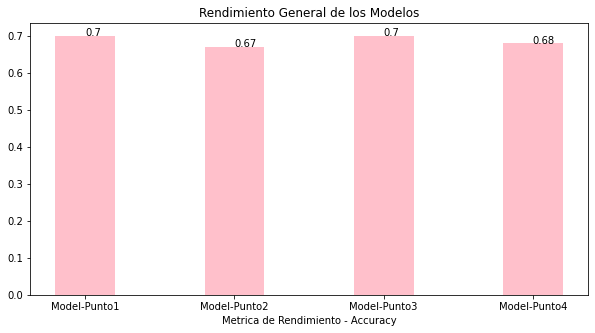

In [50]:
fig = plt.figure(figsize = (10, 5))

list_mse =[model1,model2,model3, model4]
list_mse = [round(x,2) for x in list_mse]
legens = ['Model-Punto1', 'Model-Punto2', 'Model-Punto3', 'Model-Punto4']
plt.bar(legens, list_mse, color ='pink',
        width = 0.4)
plt.xlabel("Metrica de Rendimiento - Accuracy")
plt.title("Rendimiento General de los Modelos")
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(legens,list_mse,plt)
plt.show()